In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [5]:
data = pd.read_csv('/Users/csuen/Desktop/Sun-NG-24/radicals/representative regions/UKESM1-0-LL_2010_2014_representative_regions(ver240113).csv')

#### Calculate dynamic regression 

In [6]:
d_oh_ho2_beta = data.groupby('region').apply(lambda g: sm.OLS(g['oh_mole'], g[['ho2_mole']]).fit().params)
d_oh_ho2_ste = data.groupby('region').apply(lambda g: sm.OLS(g['oh_mole'], g[['ho2_mole']]).fit().HC0_se)

In [7]:
d_oh_ho2_beta

,ho2_mole
region,
AUS,0.091431
BRA,0.019462
BTH,3.400739
CA,0.372736
CCE,0.195180
COD,0.020571
DEU,0.371617
FIN,0.056907
FRA,0.153248


#### Calculate features

In [8]:
a = data['k5'].mean()
#b = data['k8'].mean()
b = 6.34*10**(-15)
c = data['k6'].mean()

#data['c'] = data['co_mole']*a/c + data['hcho_mole']
data['c'] = data['co_mole']*a/c + data['ch4_mole']*b/c + data['hcho_mole']
#data['c'] = data['co_mole'] + data['hcho_mole']
#data['c'] = data['co_mole']
data['no__co_ch4_hcho'] = data['no_mole']/data['c']
feat = data.groupby('region').mean()[['no__co_ch4_hcho']]
feat = pd.DataFrame(feat)
feat_std = data.groupby('region').std()['no__co_ch4_hcho']
feat_ct = data.groupby('region').count()['no__co_ch4_hcho']
feat_ste = pd.DataFrame(feat_std/np.sqrt(feat_ct/5))

In [10]:
print(a/c)

0.016541058647675896


In [11]:
print(b/c)

0.0007282660543490902


In [6]:
mod = LinearRegression()
X = feat[['no__co_ch4_hcho']]
y = d_oh_ho2_beta['ho2_mole']
mod.fit(X,y)
y_pred = mod.predict(X)

In [7]:
d_oh_ho2_beta['beta_adj'] = d_oh_ho2_beta['ho2_mole'] + y_pred*0
d_oh_ho2_beta['no__co_ch4_hcho'] = feat['no__co_ch4_hcho']
d_oh_ho2_beta['beta_adj_ste'] = d_oh_ho2_ste
d_oh_ho2_beta['no__co_ch4_hcho_ste'] = feat_ste

([<matplotlib.axis.XTick at 0x7fc2f77a35b0>,
 [Text(-4, 0, '−4'),
  Text(-3, 0, '−3'),
  Text(-2, 0, '−2'),
  Text(-1, 0, '−1'),
  Text(0, 0, '0'),
  Text(1, 0, '1')])

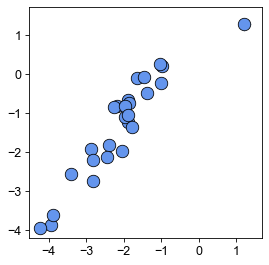

In [8]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=75)
x_values = np.log(d_oh_ho2_beta['beta_adj'])
y_values = np.log(d_oh_ho2_beta['no__co_ch4_hcho'])
x_errors = d_oh_ho2_beta['beta_adj_ste']
y_errors = d_oh_ho2_beta['no__co_ch4_hcho_ste']

plt.errorbar(x_values, y_values, xerr=x_errors, yerr=y_errors, 
             fmt="o", ecolor="grey", elinewidth=0.5, capsize=None, mfc='cornflowerblue', mec='black', ms=12, alpha=1, mew=0.75)

#plt.xlim([-4.75,1.75])
#plt.ylim([-4.75,2.75])
plt.yticks([-4,-3,-2,-1,0,1], fontsize=12)
plt.xticks([-4,-3,-2,-1,0,1], fontsize=12)

In [9]:
d_oh_ho2_beta = d_oh_ho2_beta[['beta_adj', 'beta_adj_ste', 'no__co_ch4_hcho', 'no__co_ch4_hcho_ste']]
d_oh_ho2_beta['ln_beta_adj'] = np.log(d_oh_ho2_beta['beta_adj'])
d_oh_ho2_beta['ln_no__co_ch4_hcho'] = np.log(d_oh_ho2_beta['no__co_ch4_hcho'])

d_oh_ho2_beta.to_csv('I6 OH_HO2.csv')